# Preprocessing

## Imports libraries

In [1]:
import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")
import brain_mets_classification.config as config
import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm
from datetime import datetime
import shutil
import matplotlib.pyplot as plt

import pandas as pd
import os
import pathlib
import ants
from typing import Union, List, Tuple
import multiprocessing
import SimpleITK as sitk
from nipype.interfaces.dcm2nii import Dcm2niix
import numpy as np
#from HD_BET.run import run_hd_bet
from nipype.interfaces import fsl
#from intensity_normalization.normalize.zscore import ZScoreNormalize

In [4]:
path_to_all_patients = config.path_to_ssd
path_to_n30 = config.path_to_n30

folder_to_patients = "Rgb_Brain_Mets_Preprocessing1_20240113-163435"

path_to_preprocessing = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/Rgb_Brain_Mets_Dataset/N30/preprocessing_20240115-152927"

root = f"{path_to_n30}/{folder_to_patients}"

## Extract Dicom Metadata from Dicom Files

https://medium.com/@ashkanpakzad/reading-editing-dicom-metadata-w-python-8204223a59f6

https://github.com/pydicom/pydicom

In [8]:
# Get metadata for each sequence from the first file in each sequence

import pydicom

path = path_to_n30

# gets only the folders at path and puts them in an array 
patient_folders = [
    folder for folder in os.listdir(os.path.join(path, folder_to_patients)) if os.path.isdir(os.path.join(path, folder_to_patients, folder))
]

# loop through patient folders
for patient_folder in tqdm(patient_folders):

    # ignores the ds_folders
    if config.dsStore in patient_folder:
        continue

    patientID = patient_folder
    
    path_to_patient = os.path.join(path, folder_to_patients, patient_folder)

    # get the different sequences (stored in folders) for each patient and put them in an array
    sequences = [
        folder for folder in os.listdir(path_to_patient) if os.path.isdir(os.path.join(path_to_patient, folder))
    ]
    
    # loop through the sequences, get the first file in each folder, extract metadata and safe in the patient folder
    for sequence in sequences:

        # example sequence name: 12345678_T1_0_SEQUENCENAME
        sequenceType = sequence.split("_")[1]
        sequenceName = sequence.split("_", 3)[3]
        
        # get first file in the sequence folder
        first_dicom_file_found = os.listdir(os.path.join(path_to_patient, sequence))[0]
        path_to_dicom = os.path.join(path_to_patient, sequence, first_dicom_file_found)

        # get the dicomFile metadata
        dicomFile = pydicom.dcmread(path_to_dicom)

        # puts the metadata in txt file
        txt_file_name = f"{path_to_patient}/{patientID}_{sequenceType}_{sequenceName}_metadata.txt"
        with open(txt_file_name, "w") as f:
            f.writelines(str(dicomFile))


100%|██████████| 27/27 [00:00<00:00, 44.59it/s]


## Step 00: Convert Dicom to Nifti Files
using Dcm2niix, for more information: https://github.com/rordenlab/dcm2niix

Li X, Morgan PS, Ashburner J, Smith J, Rorden C (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56. doi: 10.1016/j.jneumeth.2016.03.001. PMID: 26945974

In [ ]:
# gets only the folders at path and puts them in an array 
patient_folders = [
    folder for folder in os.listdir(root) if os.path.isdir(os.path.join(root, folder))
]

for patient in tqdm(patient_folders):

    # ignores the ds_folders
    if config.dsStore in patient:
        continue

    patientID = patient

    # get the different sequences (stored in folders) for each patient and put them in an array
    sequences = [
        sequenceFolder for sequenceFolder in os.listdir(os.path.join(root, patient)) if os.path.isdir(os.path.join(root, patient, sequenceFolder))
    ]

    # loop through the different sequences
    for sequence in sequences:

        # ignores the ds_folders
        if config.dsStore in sequence:
            continue

        # example sequence name: 12345678_T1_0_SEQUENCENAME
        sequenceType = sequence.split("_")[1]

        # new sequence name: {patientID}_{sequence}_{preprocessingStep}
        converter = Dcm2niix()
        converter.inputs.source_dir = os.path.join(root, patient, sequence)
        converter.inputs.compress = "y" # uses compression, "y" = yes
        converter.inputs.merge_imgs = True
        # converter.inputs.compression = 5
        converter.inputs.out_filename = f"{patientID}_{sequenceType}"
        converter.inputs.output_dir = os.path.join(root, patient)
        converter.run()

## Step 01: Copy nifti files in preprocessing directory

In [9]:
# To-do:
# create new directory for the preprocessing steps
# copy nifit files from old directory into preprocessing directy inside a patient folder
# Goal:
# 12345678
#    12345678_T1.nii.gz
#    12345678_T1CE.nii.gz
#    12345678_T2.nii.gz
#    ...

# create new directory
now = datetime.now()
timeFormatted = now.strftime("%Y%m%d-%H%M%S")
path_to_preprocessing = f"{path_to_n30}/preprocessing_{timeFormatted}"
os.mkdir(path_to_preprocessing)

# gets only the folders at path and puts them in an array 
patient_folders = [
    folder for folder in os.listdir(root) if os.path.isdir(os.path.join(root, folder))
]

for patient in tqdm(patient_folders):

    # ignores the ds_folders
    if config.dsStore in patient:
        continue

    patientID = patient

    # creates a new folder in the preprocessing directory
    funcs.createFolderForPatient(path_to_preprocessing, patientID)

    # get the nifti fils for each patient and put them in an array
    niftiFiles = [
        niftiFile for niftiFile in os.listdir(os.path.join(root, patient)) if (".nii.gz" in niftiFile)
    ]

    # loop through the different sequences
    for nifti in niftiFiles:
            
        # example sequence name: 12345678_T1.nii.gz
        sequenceType = (nifti.split("_")[1]).split(".")[0]

        # copy sequence
        shutil.copy(os.path.join(root, patientID, nifti), f"{path_to_preprocessing}/{patientID}/{patientID}_{sequenceType}.nii.gz")


100%|██████████| 27/27 [00:00<00:00, 118.83it/s]


## Step 02: Extract Brain
applies FSL.Reorient2Std() (requirement for HD-BET) and returns the extracted brain image

Brain Extraction using HD-BET, for more information: https://github.com/MIC-DKFZ/HD-BET

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. Hum Brain Mapp. 2019; 1–13. https://doi.org/10.1002/hbm.24750

### Step 02.1 Reorient Images

In [6]:
# create new directory
# now = datetime.now()
# timeFormatted = now.strftime("%Y%m%d-%H%M%S")
# path_to_reoriented = f"{path_to_n30}/preprocessing_reoriented_{timeFormatted}"
# os.mkdir(path_to_reoriented)

# gets only the folders at path and puts them in an array 
patient_folders = [
    folder for folder in os.listdir(path_to_preprocessing) if os.path.isdir(os.path.join(path_to_preprocessing, folder))
]

for patient in tqdm(patient_folders):

    # ignores the ds_folders
    if config.dsStore in patient:
        continue

    patientID = patient

    # get the nifti fils for each patient and put them in an array
    niftiFiles = [
        niftiFile for niftiFile in os.listdir(os.path.join(path_to_preprocessing, patient)) if (".nii.gz" in niftiFile)
    ]

    # loop through the different sequences
    for nifti in niftiFiles:

        # example sequence name: 12345678_T1.nii.gz
        sequenceType = (nifti.split("_")[1]).split(".")[0]

        now = datetime.now()
        timeFormatted = now.strftime("%Y%m%d-%H%M%S")

        path_to_input_image = os.path.join(path_to_preprocessing, patient, nifti)
        path_to_output_image = f"{path_to_preprocessing}/{patientID}/{patientID}_{sequenceType}_reoriented_{timeFormatted}.nii"

        reorient = fsl.Reorient2Std()
        reorient.inputs.in_file = path_to_input_image
        reorient.inputs.out_file = path_to_output_image
        reorient._output_type
        reorient.run()



  0%|          | 0/27 [00:00<?, ?it/s]

240116-09:09:50,589 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:51,153 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:51,660 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:52,168 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:52,668 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:53,125 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:54,98 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


  4%|▎         | 1/27 [00:04<01:44,  4.01s/it]

240116-09:09:54,598 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:55,58 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:55,505 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:55,964 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:56,496 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:57,23 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:57,516 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


  7%|▋         | 2/27 [00:07<01:30,  3.63s/it]

240116-09:09:57,954 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:58,423 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:58,884 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:59,334 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:09:59,813 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:00,308 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:00,784 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 11%|█         | 3/27 [00:10<01:23,  3.46s/it]

240116-09:10:01,218 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:01,670 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:02,189 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:02,695 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:03,124 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:03,586 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:04,51 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 15%|█▍        | 4/27 [00:13<01:18,  3.41s/it]

240116-09:10:04,539 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:04,954 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:05,462 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:05,915 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:06,389 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:06,911 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:07,414 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 19%|█▊        | 5/27 [00:17<01:14,  3.38s/it]

240116-09:10:07,885 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:08,321 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:08,782 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:09,262 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:09,695 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:10,135 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:10,602 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 22%|██▏       | 6/27 [00:20<01:09,  3.33s/it]

240116-09:10:11,119 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:11,574 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:12,48 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:12,541 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:13,25 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:13,562 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:14,39 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 26%|██▌       | 7/27 [00:23<01:06,  3.35s/it]

240116-09:10:14,497 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:14,981 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:15,493 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:16,6 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:16,495 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:17,8 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:17,436 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 30%|██▉       | 8/27 [00:27<01:03,  3.35s/it]

240116-09:10:17,858 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:18,348 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:18,861 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:19,331 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:19,827 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:20,321 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:20,808 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 33%|███▎      | 9/27 [00:30<01:00,  3.38s/it]

240116-09:10:21,303 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:21,754 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:22,234 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:22,750 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:23,261 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:23,742 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:24,236 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 37%|███▋      | 10/27 [00:34<00:57,  3.41s/it]

240116-09:10:24,769 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:25,320 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:25,854 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:26,346 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:26,846 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:27,374 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:27,897 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 41%|████      | 11/27 [00:37<00:55,  3.47s/it]

240116-09:10:28,382 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:28,842 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:29,332 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:29,864 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:30,353 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 44%|████▍     | 12/27 [00:40<00:47,  3.17s/it]

240116-09:10:30,850 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:31,362 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:31,901 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:32,387 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:32,908 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:33,398 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:33,879 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 48%|████▊     | 13/27 [00:43<00:45,  3.27s/it]

240116-09:10:34,353 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:34,899 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:35,428 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:35,902 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:36,436 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:36,951 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:37,456 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 52%|█████▏    | 14/27 [00:47<00:43,  3.36s/it]

240116-09:10:37,923 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:38,427 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:38,897 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:39,396 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:39,891 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:40,372 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:40,885 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 56%|█████▌    | 15/27 [00:50<00:40,  3.39s/it]

240116-09:10:41,388 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:41,868 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:42,361 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:42,853 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:43,307 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:43,803 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 59%|█████▉    | 16/27 [00:53<00:35,  3.24s/it]

240116-09:10:44,290 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:44,804 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:45,304 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:45,769 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:46,260 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:46,757 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:47,225 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 63%|██████▎   | 17/27 [00:57<00:32,  3.29s/it]

240116-09:10:47,697 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:48,219 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:49,586 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:50,220 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:50,777 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:51,268 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:51,829 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:52,306 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 67%|██████▋   | 18/27 [01:02<00:34,  3.83s/it]

240116-09:10:52,765 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:53,266 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:53,732 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:54,224 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:54,724 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:55,186 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:55,645 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 70%|███████   | 19/27 [01:05<00:29,  3.69s/it]

240116-09:10:56,147 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:56,635 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:57,134 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:57,639 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:58,89 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:58,583 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:59,75 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 74%|███████▍  | 20/27 [01:08<00:25,  3.60s/it]

240116-09:10:59,526 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:10:59,982 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:00,440 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:00,926 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:01,407 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:01,885 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:02,377 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 78%|███████▊  | 21/27 [01:12<00:21,  3.52s/it]

240116-09:11:02,862 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:03,379 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:03,871 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:04,423 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:04,893 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:05,373 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 81%|████████▏ | 22/27 [01:15<00:16,  3.36s/it]

240116-09:11:05,853 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:06,318 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:06,804 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:07,327 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:07,762 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:08,240 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:08,728 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 85%|████████▌ | 23/27 [01:18<00:13,  3.35s/it]

240116-09:11:09,189 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:09,648 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:10,123 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:10,608 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:11,86 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:11,540 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:12,4 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 89%|████████▉ | 24/27 [01:21<00:10,  3.35s/it]

240116-09:11:12,529 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:13,20 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:13,516 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:14,2 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:14,455 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:14,915 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:15,404 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 93%|█████████▎| 25/27 [01:25<00:06,  3.35s/it]

240116-09:11:15,892 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:16,377 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:16,820 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:17,280 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:17,791 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:18,246 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:18,705 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


 96%|█████████▋| 26/27 [01:28<00:03,  3.33s/it]

240116-09:11:19,155 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:19,694 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:20,210 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:20,674 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:21,175 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:21,695 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
240116-09:11:22,185 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


100%|██████████| 27/27 [01:32<00:00,  3.41s/it]


### Step 02.2 Extract Brain using HD-BET

currently not working as HD-BET is not supported for apple silicons, but trying to find another way

In [ ]:
# gets only the folders at path and puts them in an array 
patient_folders = [
    folder for folder in os.listdir(path_to_preprocessing) if os.path.isdir(os.path.join(path_to_preprocessing, folder))
]

for patient in tqdm(patient_folders):

    # ignores the ds_folders
    if config.dsStore in patient:
        continue

    patientID = patient

    reorientedNiftiFiles = [
        reorientedFile for reorientedFile in os.listdir(path_to_preprocessing, patient) if ("reoriented" in reorientedFile)
    ]

    # loop through the reoriented files
    for reorientedFile in reorientedNiftiFiles:

        sequenceType = (nifti.split("_")[1]).split(".")[0]

        now = datetime.now()
        timeFormatted = now.strftime("%Y%m%d-%H%M%S")

        path_to_input_image = os.path.join(path_to_preprocessing, patient, reorientedFile)
        path_to_output_image = f"{path_to_preprocessing}/{patient}/{patientID}_{sequenceType}_brainextracted_{timeFormatted}"

        # either like this
        #run_hd_bet(mri_fnames=path_to_output_image, output_fnames=path_to_output_image)

        # or like that
        os.system(f"hd-bet -i {path_to_input_image} -o {path_to_output_image}")

## Step 03: Fill Holes

In [ ]:
# gets only the folders at path and puts them in an array 
patient_folders = [
    folder for folder in os.listdir(path_to_preprocessing) if os.path.isdir(os.path.join(path_to_preprocessing, folder))
]

for patient in tqdm(patient_folders):

    # ignores the ds_folders
    if config.dsStore in patient:
        continue

    patientID = patient

    brainExtractedFiles = [
        reorientedFile for reorientedFile in os.listdir(path_to_preprocessing, patient) if ("brainextracted" in reorientedFile)
    ]

    # loop through the brain extracted files
    for betFile in brainExtractedFiles:

        path_to_bet_file = os.path.join(path_to_preprocessing, patient, betFile)
        sitk_image = sitk.ReadImage(path_to_bet_file, imageIO="NiftiImageIO")

        otsu_filter = sitk.OtsuMultipleThresholdsImageFilter()
        otsu_filter.SetInsideValue(0)
        otsu_filter.SetOutsideValue(1)
        otsu_image = otsu_filter.Execute(sitk_image)


        sequenceType = (nifti.split("_")[1]).split(".")[0]

        now = datetime.now()
        timeFormatted = now.strftime("%Y%m%d-%H%M%S")

        path_to_output_image = f"{path_to_preprocessing}/{patientID}/{patientID}_{sequenceType}_holesfilled_{timeFormatted}.nii.gz"
        sitk.WriteImage(otsu_image, path_to_output_image, imageIO = "NiftiImageIO")

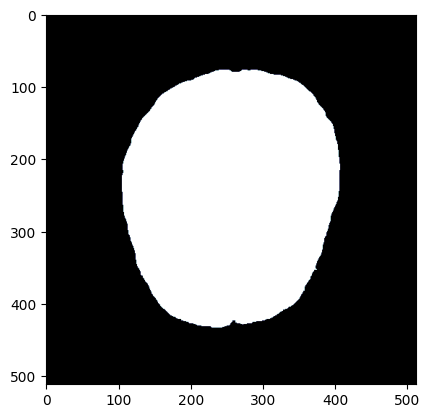

In [18]:
example_image = "/Users/LennartPhilipp/Desktop/01199093_T1a_brainextracted.nii.gz"

sitk_image = sitk.ReadImage(example_image, imageIO="NiftiImageIO")
# array = sitk.GetArrayFromImage(sitk_t1)
# print(array.shape)
# slice = array[16, :, :]
# print(slice.shape)
# plt.imshow(slice, cmap="bone")
# plt.colorbar()

otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
otsu_image = otsu_filter.Execute(sitk_image)

closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
closing_filter.SetKernelRadius(3)
closed_image = closing_filter.Execute(otsu_image)

plt.imshow(sitk.GetArrayFromImage(closed_image)[15, :, :], cmap="bone")

In [48]:
def fill_holes(
    binary_image: sitk.Image,
    radius: int = 3,
) -> sitk.Image:
    """
    Fills holes in binary segmentation

    Keyword Arguments:
    - binary_image: sitk.Image = binary brain segmentation
    - radius: int = kernel radius

    Returns:
    - closed_image: sitk.Image = binary brain segmentation with holes filled
    """

    closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
    closing_filter.SetKernelRadius(radius)
    closed_image = closing_filter.Execute(binary_image)

    return closed_image

## Step 04: Binary Segment Brain

In [47]:
def binary_segment_brain(
    image: sitk.Image,
) -> sitk.Image:
    """
    Returns binary segmentation of brain from brain-extracted scan via otsu thresholding

    Keyword Arguments:
    - image: sitk.Image = brain-extracted scan

    Returns:
    - sitk.Image = binary segmentation of brain scan with filled holes
    """

    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    binary_mask = otsu_filter.Execute(image)

    return fill_holes(binary_mask)

## Step 05: Get Bounding Box

In [ ]:
def get_bounding_box(
    image: sitk.Image,
) -> Tuple[int]:
    """
    Returns bounding box of brain-extracted scan

    Keyword Arguments:
    - image: sitk.Image = brain-extracted scan

    Returns
    - bounding_box: Tuple(int) = bounding box (startX, startY, startZ, sizeX, sizeY, sizeZ)
    """

    mask_image = binary_segment_brain(image)

    lsif = sitk.LabelShapeStatisticsImageFilter()
    lsif.Execute(mask_image)
    bounding_box = np.array(lsif.GetBoundingBox(1))

    return bounding_box

## Step 06: Apply Bounding Box

In [ ]:
def apply_bounding_box(
    image: sitk.Image,
    bounding_box: Tuple[int],
) -> sitk.Image:
    """
    Returns image, cropped to bounding box

    Keyword Arguments:
    - image: sitk.Image = image
    - bounding_box: Tuple(ing) = bounding box of kind (startX, startY, startZ, sizeX, sizeY, sizeZ)

    Returns
    - cropped_image: sitk.Image = cropped image
    """

    cropped_image = image[
        bounding_box[0] : bounding_box[3] + bounding_box[0],
        bounding_box[1] : bounding_box[4] + bounding_box[1],
        bounding_box[2] : bounding_box[5] + bounding_box[2],
    ]

    return cropped_image

## Step 07: Apply Bias Correction

In [ ]:
def apply_bias_correction(
    image: sitk.Image,
) -> sitk.Image:
    """applies N4 bias field correction to image but keeps background at zero

    Keyword Arguments:
    image: sitk.Image = image to apply bias correction to

    Returns:
    image_corrected_masked: sitk.Image = N4 bias field corrected image
    """

    mask_image = binary_segment_brain(image)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    image_corrected = corrector.Execute(image, mask_image)

    mask_filter = sitk.MaskImageFilter()
    mask_filter.SetOutsideValue(0)
    image_corrected_masked = mask_filter.Execute(image_corrected, mask_image)

    return image_corrected_masked

## Step 08: Coregister Images

In [ ]:
def coregister_antspy(
    fixed_path: Union[str, pathlib.Path],
    moving_path: Union[str, pathlib.Path],
    out_path: Union[str, pathlib.Path],
    num_threads=N_PROC,
) -> ants.core.ants_image.ANTsImage:
    """
    Coregister moving image to fixed image. Return warped image and save to disk.

    Keyword Arguments:
    fixed_path: path to fixed image
    moving_path: path to moving image
    out_path: path to save warped image to
    num_threads: number of threads
    """

    os.environ["ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS"] = str(num_threads)

    res = ants.registration(
        fixed=ants.image_read(fixed_path),
        moving=ants.image_read(moving_path),
        type_of_transform="antsRegistrationSyNQuick[s]",  # or "SyNRA"
        initial_transform=None,
        outprefix="",
        mask=None,
        moving_mask=None,
        mask_all_stages=False,
        grad_step=0.2,
        flow_sigma=3,
        total_sigma=0,
        aff_metric="mattes",
        aff_sampling=32,
        aff_random_sampling_rate=0.2,
        syn_metric="mattes",
        syn_sampling=32,
        reg_iterations=(40, 20, 0),
        aff_iterations=(2100, 1200, 1200, 10),
        aff_shrink_factors=(6, 4, 2, 1),
        aff_smoothing_sigmas=(3, 2, 1, 0),
        write_composite_transform=False,
        random_seed=None,
        verbose=False,
        multivariate_extras=None,
        restrict_transformation=None,
        smoothing_in_mm=False,
    )

    warped_moving = res["warpedmovout"]

    ants.image_write(warped_moving, out_path)

    return warped_moving

## Step 09: Resample Images

In [ ]:
def resample(
    itk_image: sitk.Image,
    out_spacing: Tuple[float, ...],
    is_mask: bool,
) -> sitk.Image:
    """
    Resamples sitk image to expected output spacing

    Keyword Arguments:
    itk_image: sitk.Image
    out_spacing: Tuple
    is_mask: bool = True if input image is label mask -> NN-interpolation

    Returns
    output_image: sitk.Image = image resampled to out_spacing
    """

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(round(osz * osp / nsp))
        for osz, osp, nsp in zip(original_size, original_spacing, out_spacing)
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(0)

    if is_mask:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    else:
        resample.SetInterpolator(
            sitk.sitkBSpline
        )  # sitk.sitkLinear sitk.sitkNearestNeighbor

    output_image = resample.Execute(itk_image)

    return output_image

## Step 10: Z-Score Normalize Images

In [ ]:
def zscore_normalize(image: sitk.Image) -> sitk.Image:
    """
    Applies z score normalization to brain scan using a brain mask

    Keyword Arguments:
    image: sitk.Image = input brain scan

    Returns:
    normalized_brain_image: sitk.Image = normalized brain scan
    """

    brain_mask = binary_segment_brain(image)

    normalizer = ZScoreNormalize()
    normalized_brain_array = normalizer(
        sitk.GetArrayFromImage(image),
        sitk.GetArrayFromImage(brain_mask),
    )

    normalized_brain_image = sitk.GetImageFromArray(normalized_brain_array)
    normalized_brain_image.CopyInformation(image)

    return normalized_brain_image